In [1]:
import gc
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
from glob import glob

from utils import loadpkl, to_json, scalingPredictions, getBestMultiple

%matplotlib inline

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [6]:
# load predictions
pred_lgbm = loadpkl('../features/lgbm_pred.pkl')
pred_xgb = loadpkl('../features/xgb_pred.pkl')
plans = loadpkl('../features/plans.pkl')

# define columns name list
cols_pred_lgbm = ['pred_lgbm_plans{}'.format(i) for i in range(0,12)]
cols_pred_xgb = ['pred_xgb_plans{}'.format(i) for i in range(0,12)]
cols_transport_mode = ['plan_{}_transport_mode'.format(i) for i in range(0,7)]

# blend predictions
pred = pred_lgbm[['sid','click_mode']]
pred = pd.merge(pred, plans[cols_transport_mode+['sid','plan_num_plans']],on='sid', how='left')

del plans
gc.collect()

# scaling
pred_lgbm[cols_pred_lgbm] = scalingPredictions(pred_lgbm[cols_pred_lgbm])
pred_xgb[cols_pred_xgb] = scalingPredictions(pred_xgb[cols_pred_xgb])

# reset index
pred_lgbm.reset_index(inplace=True,drop=True)
pred_xgb.reset_index(inplace=True,drop=True)

for i in range(1,12):
    tmp = np.zeros(len(pred))
    for c in cols_transport_mode:
        tmp += (pred[c]==i).astype(int)
    pred_lgbm['pred_lgbm_plans{}'.format(i)]=pred_lgbm['pred_lgbm_plans{}'.format(i)]*(tmp>0)
    pred_xgb['pred_xgb_plans{}'.format(i)]=pred_xgb['pred_xgb_plans{}'.format(i)]*(tmp>0)
    
cols_pred =[]
for i in range(0,12):
    pred['pred_{}'.format(i)] = 0.5*pred_lgbm['pred_lgbm_plans{}'.format(i)]+ 0.5*pred_xgb['pred_xgb_plans{}'.format(i)]
    cols_pred.append('pred_{}'.format(i))

/media/fujiwara/2THDD/KDD-Cup-2019/src/utils.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pred_df['pred_min'] = pred_df[cols_pred].min(axis=1)


In [7]:
pred['recommend_mode'] = np.argmax(pred[cols_pred].values,axis=1)
pred['recommend_mode'][(pred['plan_num_plans']==1)&(pred['recommend_mode']!=0)] = pred['plan_0_transport_mode'][(pred['plan_num_plans']==1)&(pred['recommend_mode']!=0)]

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
# split train & test
oof_pred = pred[pred['click_mode'].notnull()]
sub_pred = pred[pred['click_mode'].isnull()]

oof_pred['pred_0']*=1.57
#oof_pred['pred_4']*=1.13
oof_pred['recommend_mode'] = np.argmax(oof_pred[cols_pred].values,axis=1)

# out of fold score
oof_f1_score = f1_score(oof_pred['click_mode'], oof_pred['recommend_mode'],average='weighted')
oof_f1_score

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0.6725579034495828

In [9]:
w_click = oof_pred.click_mode.astype(int).value_counts(normalize=True).to_dict()
w_recommend = oof_pred.recommend_mode.value_counts(normalize=True).to_dict()

In [10]:
for i, c in enumerate(cols_pred):
    print(w_click[i]/w_recommend[i])

14.158408408408407
0.834002962962963
0.9003779857909007
3.817984496124031
27.344902386117138
0.8549717290308639
2.024057328101007
0.8355305328832101
1.3160878809355068
0.8026676741626558
0.7447330230696091
0.7388666423977672


In [17]:
def getBestMultiple(pred_df, col, cols_pred, output):
    best_f1=0.0
    best_m = 1.0
    f1s = []
    for _m in np.arange(1.0,2.0,0.01):
        tmp_pred = pred_df[cols_pred]
        tmp_pred[col] *= _m
        _f1 = f1_score(pred_df['click_mode'], np.argmax(tmp_pred.values,axis=1),average='weighted')
        f1s.append(_f1)
        print('multiple: {}, f1 score: {}'.format(_m,_f1))
        if _f1 > best_f1:
            best_f1 = _f1
            best_m = _m
        del tmp_pred
    # plot thresholds
    plt.figure()
    plt.plot(np.arange(1.0,2.0,0.01), f1s)
    plt.savefig(output)

    return best_m

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


multiple: 1.0, f1 score: 0.6673437324314919
multiple: 1.01, f1 score: 0.6674620386482394
multiple: 1.02, f1 score: 0.6676478242703983
multiple: 1.03, f1 score: 0.667745331680426
multiple: 1.04, f1 score: 0.6678666300910207
multiple: 1.05, f1 score: 0.6680348738132594
multiple: 1.06, f1 score: 0.6682212256767697
multiple: 1.07, f1 score: 0.6683184877800256
multiple: 1.08, f1 score: 0.6684017766931544
multiple: 1.09, f1 score: 0.6685218299709454
multiple: 1.1, f1 score: 0.6685901058321567
multiple: 1.11, f1 score: 0.668736386652501
multiple: 1.12, f1 score: 0.6688769707393154
multiple: 1.1300000000000001, f1 score: 0.6690142783418992
multiple: 1.1400000000000001, f1 score: 0.669099832732028
multiple: 1.1500000000000001, f1 score: 0.6692511006718468
multiple: 1.1600000000000001, f1 score: 0.6693580138297079
multiple: 1.1700000000000002, f1 score: 0.6694660268610858
multiple: 1.1800000000000002, f1 score: 0.6695931355909637
multiple: 1.1900000000000002, f1 score: 0.6696740653990918
multipl

1.5700000000000005

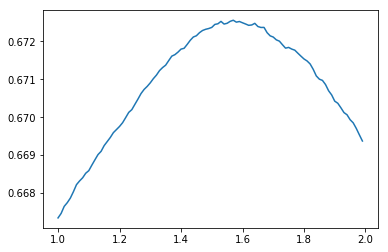

In [18]:
getBestMultiple(oof_pred,'pred_0',cols_pred,'../imp/multiple0.png')

In [11]:
oof_pred[cols_pred]

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11
0,0.122563,0.089278,0.159251,0.091397,0.066360,0.000000,0.000000,0.000000,0.000000,0.446900,0.000000,0.000000
1,0.086975,0.000000,0.597601,0.073392,0.064322,0.066188,0.074504,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.128660,0.128148,0.000000,0.106861,0.089754,0.000000,0.000000,0.513226,0.000000,0.000000,0.000000,0.000000
3,0.109485,0.000000,0.548793,0.063473,0.066186,0.000000,0.066140,0.102757,0.000000,0.000000,0.000000,0.000000
4,0.107338,0.134104,0.000000,0.092354,0.088496,0.000000,0.000000,0.538513,0.000000,0.000000,0.000000,0.000000
5,0.198230,0.000000,0.000000,0.622710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.098168,0.000000,0.579484,0.074275,0.075442,0.064276,0.070997,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.111831,0.103498,0.485162,0.103361,0.075220,0.000000,0.000000,0.000000,0.000000,0.096387,0.000000,0.000000
8,0.089926,0.085665,0.519522,0.072608,0.070499,0.000000,0.051159,0.000000,0.000000,0.084612,0.000000,0.000000
9,0.113479,0.462964,0.000000,0.078911,0.067064,0.122583,0.124648,0.000000,0.000000,0.000000,0.000000,0.000000
